In [505]:
%matplotlib inline
import numpy as np

import torch

#seed=1337
#torch.manual_seed(seed)
#torch.cuda.manual_seed_all(seed)

    
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import torch.utils.data as data
from torch.autograd import Variable

from torchvision.transforms import Compose, RandomCrop, ToTensor, Scale, RandomHorizontalFlip, CenterCrop, ToPILImage

from PIL import Image, ImageFilter

import os
import sys
sys.path.append('../')

from model import LapSRN
from loss import CharbonnierLoss, make_vgg16_loss
from skimage.filters import frangi
from skimage.filters import threshold_otsu


In [673]:
to_pil = ToPILImage()

model = LapSRN(depth=10).cuda().eval()

continue_training = True # TODO!
if continue_training:
    checkpoint = torch.load('../../checkpoints_camp/srn_3330.pt')
    #checkpoint = torch.load('../../best_checkpoints/l1.pt')
    #checkpoint = torch.load('../../checkpoints_l1/srn_15318.pt')
    model.load_state_dict(checkpoint['model_state'])
    #optimizer.load_state_dict(checkpoint['optim_state'])
    epoch = checkpoint['epoch']

0.950487991873 0.947306420059 42.3347322318 40.162300757


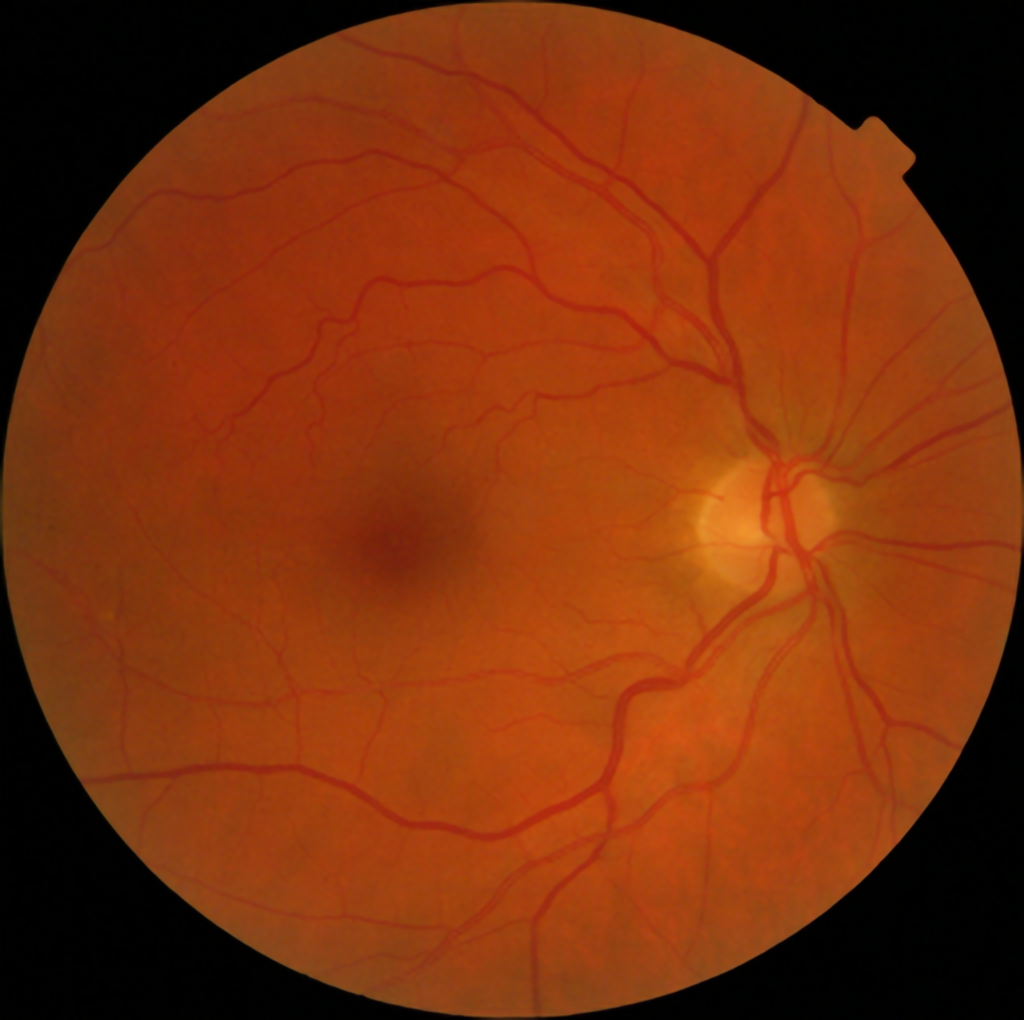

In [760]:
from torchvision.transforms import Normalize
from skimage import measure
from PIL.ImageFilter import GaussianBlur
import PIL.ImageChops as chop
import time
from dataset import RandomScaling

#chop.invert(chop.subtract(vessels(img), vessels(sr), scale=1.0)).resize((256,256), Image.BICUBIC)

def vessels(img, mask=None):
    img = np.array(img.convert('YCbCr').split()[0]).astype(float)

    # Ignore background
    if mask is None:
        thresh = threshold_otsu(img)
        black = img < thresh
    else:
        black = np.array(mask) == 0

    # Compute vessels
    vessels = frangi(img, scale_range=(2, 6), beta2=3.8, beta1=0.4)

    # Reset black pixels to black. Otherwise we get a surrounding ring.
    vessels[black] = 0.0
    vessels = (vessels > 0.2)*1.0
    vessels = Image.fromarray(vessels*255).convert('RGB')    

    return vessels

def upsample_tensor(model, lr, return_time=False, to_normalize=False):      
    mean=np.array([0.485, 0.456, 0.406])
    std=np.array([0.229, 0.224, 0.225])
    normalize = Normalize(mean=mean, std=std)
    to_tensor = ToTensor()
    
    # First create appropiate input image
    lr = to_tensor(lr)
    if to_normalize:
        lr = normalize(lr)
        
    lr = Variable(lr).cuda().unsqueeze(0)     
    def denormalize(out):
        # Undo input[channel] = (input[channel] - mean[channel]) / std[channel]
        for t, m, s in zip(out, mean, std):
            t.mul_(s)
            t.add_(m)
        return out.clamp(0,1)
    
    start = time.perf_counter()
    upscaled = model(lr)
    end = time.perf_counter()
    
    hr2, hr4 = [denormalize(out.squeeze(0).cpu().data) for out in upscaled]
    
    elapsed_time = end - start

    if return_time:
        return elapsed_time, hr2, hr4
    else:
        return hr2, hr4
    
def upsample_bic(lr):
    lr_size = np.array(lr.size)
    hr2 = lr.resize(2*lr_size, Image.BICUBIC)
    hr4 = lr.resize(4*lr_size, Image.BICUBIC)
    return hr2, hr4

def residual(y, y_hat, transform=lambda x:x):
    y = transform(y)
    y_hat = transform(y_hat)
    return chop.subtract(y, y_hat, scale=0.05)

def acc(y, y_hat, transform=lambda x:x):
    y = np.array(transform(y))
    y_hat = np.array(transform(y_hat))
    total = y.size * 1.0
    correct = ((y == y_hat)*1.0).sum()

    return (correct/total)*100

def mse(y, y_hat, transform=lambda x:x):
    y = np.array(transform(y))
    y_hat = np.array((transform(y_hat)))
    
    diff = y_hat/255.0 - y/255.0
    return np.sum(diff**2)/diff.size    

def psnr(y, y_hat, transform=lambda x:x):
    error = mse(y, y_hat, transform)
    psnr = -10 * np.log10(error)
    return psnr

# RGB:
to_tensor = ToTensor()
to_pil = ToPILImage(mode='RGB')
img_path = '../../data/raw/all-images/im0003.ppm'
img_path = '../../data/raw/DRIVE/training/images/21_training.tif'
img_path = '../../data/processed/messidor/20051205_58373_0400_PP.tif'
#img_path = '../../data/processed/messidor/20060530_55304_0100_PP.tif'

new_size = [1024, 1024]
img = Image.open(img_path)
img.thumbnail(new_size, Image.ANTIALIAS)

# Find next largest crop size that is divisible by four.
crop_size = [int(np.ceil(s/4)*4) for s in img.size]
#crop_size = [256] * 2

lr_crop_size = [s//4 for s in (crop_size)]
blur_strength = 0. # TODO.
center_crop = CenterCrop(crop_size[::-1]) # pads s.t. img is div. by 4
back_crop = CenterCrop(img.size[::-1]) # crop back to orig. img. size
back_crop = lambda x: x #center_crop

hr4_gt = center_crop(img)
hr4_blurred = hr4_gt.filter(ImageFilter.GaussianBlur(blur_strength))
lr = hr4_blurred.resize(lr_crop_size, Image.BICUBIC)

elapsed_time, *sr_out = upsample_tensor(model, lr, to_normalize=True, return_time=True)
hr2_sr, hr4_sr = [back_crop(to_pil(out)) for out in sr_out]
hr2_bic, hr4_bic = [back_crop(out) for out in upsample_bic(lr)]

hr4_gt = back_crop(center_crop(hr4_gt))

print(measure.compare_ssim(np.array(hr4_gt), np.array(hr4_sr), winsize=255, data_range=256, multichannel=True),\
measure.compare_ssim(np.array(hr4_gt), np.array(hr4_bic), winsize=255, data_range=256, multichannel=True),\
measure.compare_psnr(np.array(back_crop(hr4_gt)), np.array(back_crop(hr4_sr))),\
measure.compare_psnr(np.array(back_crop(hr4_gt)), np.array(back_crop(hr4_bic))))

hr4_sr

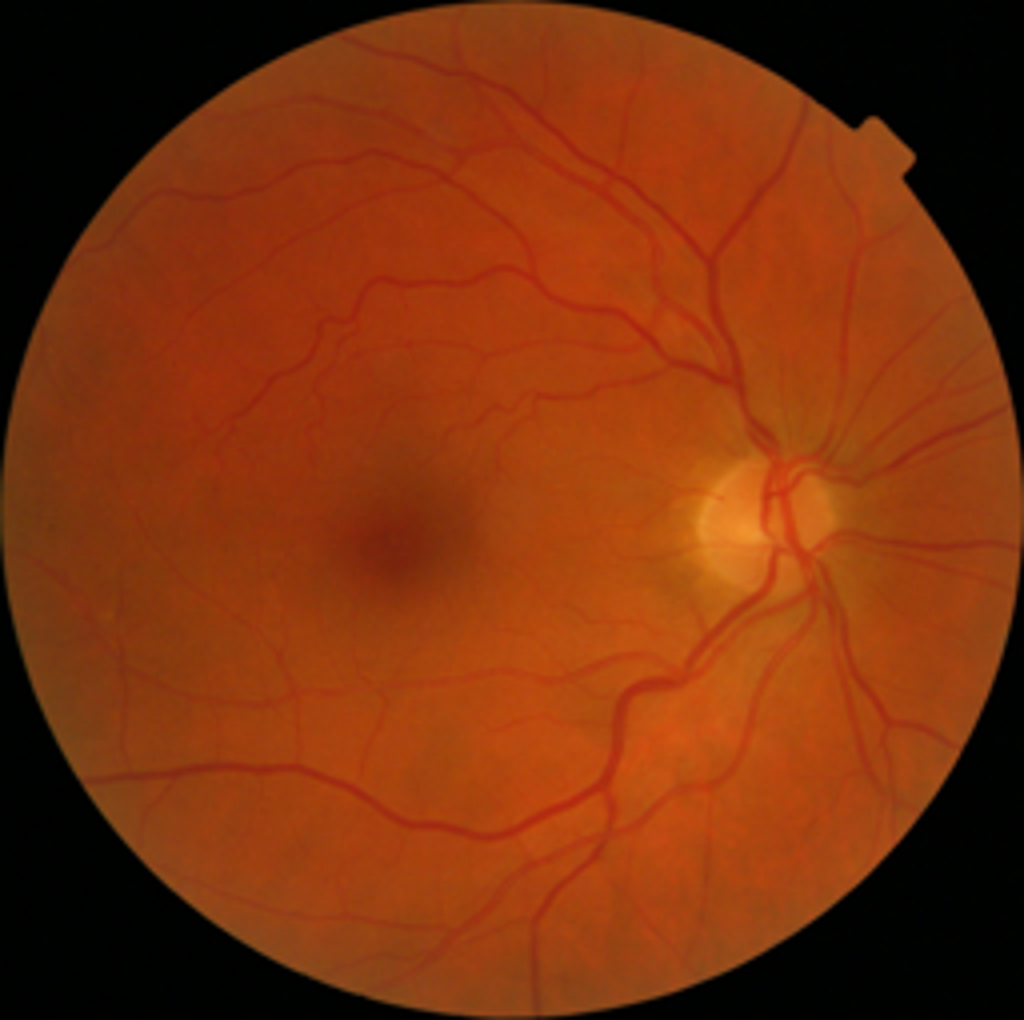

In [761]:
hr4_bic

/home/lukas/bin/anaconda3/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


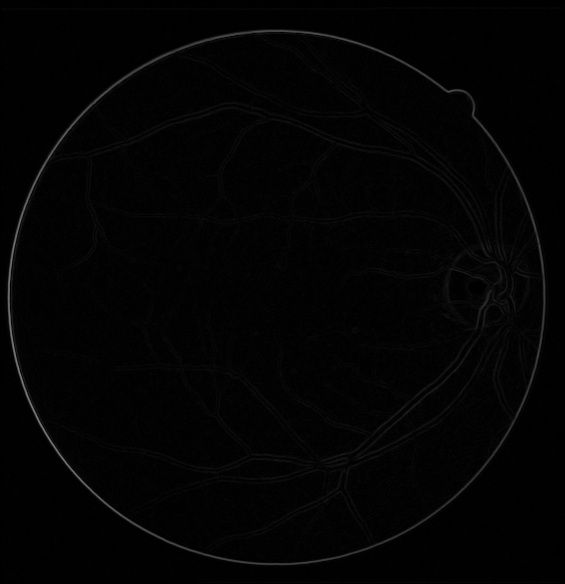

GT	87.2287550006
Blurred	87.2287550006
SR	86.7286943872
BIC	93.1597769427



GT	91.2771244999
Blurred	91.2771244999
SR	91.3271305613
BIC	90.6840223057



GT	100.0
Blurred	100.0
SR	98.1043156746
BIC	97.7957934295
3.29893100024492
10.5934032608


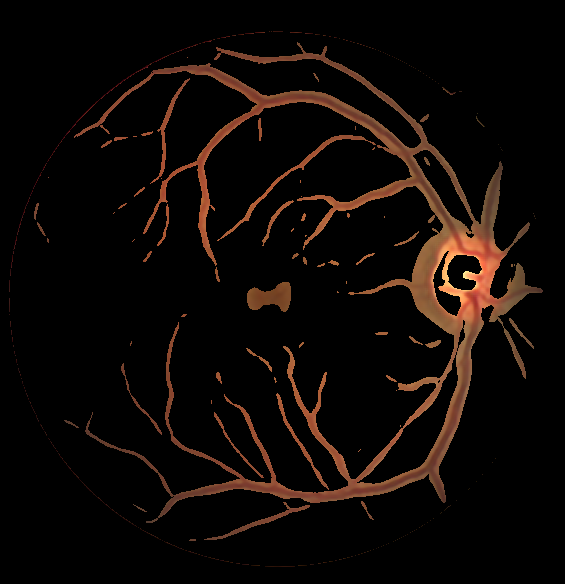

In [547]:
# Drive

from pathlib import Path
drive_dir = Path('../../data/raw/DRIVE/training/') 

num = '36'
mask = Image.open(drive_dir / 'mask/{}_training_mask.gif'.format(num)).convert('YCbCr').split()[0]
img = Image.open(drive_dir / 'images/{}_training.tif'.format(num))
gt = Image.open(drive_dir / '1st_manual/{}_manual1.gif'.format(num)).convert('YCbCr').split()[0]

#crop_size = 140*4
crop_size = [int(np.ceil(s/4)*4) for s in img.size]
#lr_crop_size = [int(np.ceil(s/4)) for s in img.size]#[::-1]
#lr_crop_size = [256//4, 128//4][::-1]
lr_crop_size = [s//4 for s in (crop_size)]
blur_strength = 0

# Center crop has mirrored coordinates.
center_crop = CenterCrop(crop_size[::-1])
#mask = center_crop(mask)
#gt = center_crop(gt)

back_crop = CenterCrop(img.size[::-1])

hr4_gt = img
hr4_blurred = hr4_gt.filter(ImageFilter.GaussianBlur(blur_strength))
lr = hr4_blurred.resize(lr_crop_size, Image.BICUBIC)

elapsed_time, *sr_out = upsample_tensor(model, lr, to_normalize=True, return_time=True)
hr2_sr, hr4_sr = [back_crop(to_pil(out)) for out in sr_out]
hr2_bic, hr4_bic = [back_crop(out) for out in upsample_bic(lr)]

print("GT" ,1000*mse(vessels(hr4_gt, mask).convert('YCbCr').split()[0], gt), sep='\t')
print("Blurred" ,1000*mse(vessels(hr4_blurred, mask).convert('YCbCr').split()[0], gt), sep='\t')
print("SR" ,1000*mse(vessels(hr4_sr, mask).convert('YCbCr').split()[0], gt), sep='\t')
print("BIC" ,1000*mse(vessels(hr4_bic, mask).convert('YCbCr').split()[0], gt), sep='\t')
print("\n\n")

print("GT" , acc(vessels(hr4_gt, mask).convert('YCbCr').split()[0], gt), sep='\t')
print("Blurred" ,acc(vessels(hr4_blurred, mask).convert('YCbCr').split()[0], gt), sep='\t')
print("SR" ,acc(vessels(hr4_sr, mask).convert('YCbCr').split()[0], gt), sep='\t')
print("BIC" ,acc(vessels(hr4_bic, mask).convert('YCbCr').split()[0], gt), sep='\t')
print("\n\n")

print("GT" , acc(vessels(hr4_gt, mask).convert('YCbCr').split()[0], (vessels(hr4_gt, mask).convert('YCbCr').split()[0])),
                  sep='\t')
print("Blurred" , acc(vessels(hr4_gt, mask).convert('YCbCr').split()[0], (vessels(hr4_blurred, mask).convert('YCbCr').split()[0])),
                  sep='\t')
print("SR" , acc(vessels(hr4_gt, mask).convert('YCbCr').split()[0], (vessels(hr4_sr, mask).convert('YCbCr').split()[0])),
                  sep='\t')
print("BIC" , acc(vessels(hr4_gt, mask).convert('YCbCr').split()[0], (vessels(hr4_bic, mask).convert('YCbCr').split()[0])),
                  sep='\t')

print(elapsed_time*1000)


print(psnr(vessels(hr4_gt, mask).convert('YCbCr').split()[0], gt))
chop.multiply(vessels(hr4_sr, mask), hr4_sr)
#vessels(hr4_sr)

In [504]:
black = Image.fromarray(np.zeros_like(np.array(hr4_gt))).convert('YCbCr').split()[0]
acc(black, gt)

89.124742393017328

/home/lukas/bin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 605 but corresponding boolean dimension is 584


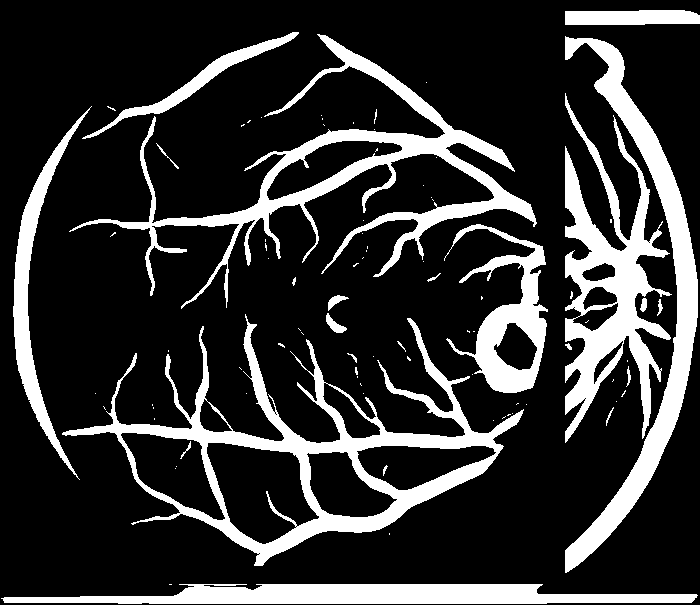

In [538]:
import skimage.io._plugins.pil_plugin as skpil
def vessels(img, mask=None):
    #img = np.array(img.convert('YCbCr').split()[0]).astype(float)
    img = skpil.pil_to_ndarray(img.convert('RGB').split()[1])
    #img = fil.median(img)

    # Ignore background
    if mask is None:
        thresh = threshold_otsu(img)
        black = img < thresh
    else:
        black = np.array(mask) == 0

    # Compute vessels
    vessels = fil.frangi(img)
    #vessels = fil.frangi(img)
    #print(vessels.mean())

    # Reset black pixels to black. Otherwise we get a surrounding ring.
    vessels[black] = 0.0
    vessels = (vessels >  4*10e-8)*1.0
    vessels = Image.fromarray(vessels*255).convert('RGB')    

    return vessels

#fig, ax = plt.subplots(1, figsize=(20,20))
##ax.imshow(vessels(hr4_sr), cmap=plt.cm.gray)
#print("GT" ,acc(vessels(hr4_gt, mask).convert('YCbCr').split()[0], gt), sep='\t')
vessels(hr4_gt, mask)


0.379853600945


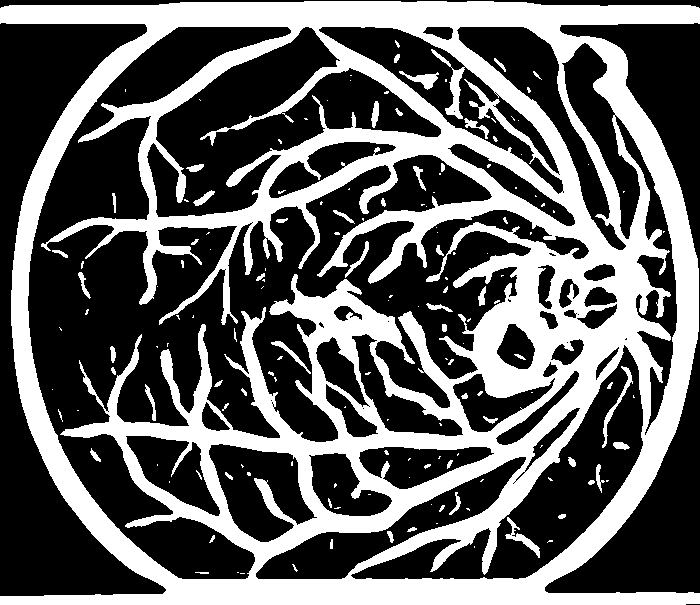

In [541]:
from skimage import exposure
arr = skpil.pil_to_ndarray(hr4_sr.convert('RGB').split()[1])
#arr = exposure.equalize_adapthist(arr)#*255.0
arr = (fil.frangi(arr) > 10e-8)*1.0
print(arr.mean())
#skpil.ndarray_to_pil(arr)
Image.fromarray(arr*255).convert('RGB')

ValueError: The parameter `image` must be a 2-dimensional array